# Calcul de la constante de Lifschitz sans entrainement
Ici on considère le modèle Forward-backward-ResNet sans entrainement.
Dans la class du modèle, le module "Lipschitz" calcule la constante de Lipschitz d'un reseau selon la méthode choisie (pour l'entrée 1 ou 2, avec une erreur sur le biais, etc.).
On vérifie d' abord que l' algorithme converge sans entrainement.
Puis on calcule sa constante de Lipschitz théorique et on compare le resultats avec deux entrées proches à une perturbation près (pas trop irrégulière).

In [1]:
# importation
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
# local
from FBResNet.myfunc import Physics
from FBResNet.myfunc import MyMatmul
from FBResNet.model import MyModel

### Paramtères

In [2]:
a   = 1
p   = 1
nx  = 2000
m   = 50
sim = Physics(nx,m,a,p)

In [3]:
folder  = './Datasets'
nsample = 50
nLayers = 20

### Fonction à reconstruire (gaussienne)

In [4]:
# Gaussian
t   = np.linspace(0,1,nx)
x   = np.exp(-(t-0.5)**2/0.01)
xc  = sim.BasisChange(x)
xi  = np.exp(-(t-0.6)**2/0.1)
xic = sim.BasisChange(x)
y   = sim.ComputeAdjoint(sim.Compute(x))
y.shape

(50,)

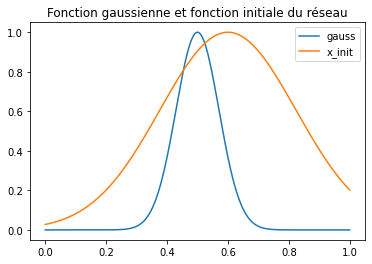

In [5]:
plt.plot(t,x,label="gauss")
plt.plot(t,xi,label="x_init")
plt.title("Fonction gaussienne et fonction initiale du réseau")
plt.legend()

### Descente de gradient

In [6]:
gamma = 0.05
xky = y.copy()
xkc = xic.copy()
tDD, tTT, Peig, Pelt = sim.Operators()
y2  = tTT.dot(sim.BasisChange(x))
for _ in range(nLayers):
    xky = xky-gamma*(tTT.dot(xky)-y2)
    xkc = xkc-gamma*(tTT.dot(xkc)-y2)

### Modele non entrainé

In [7]:
mymodel = MyModel(sim,nL=nLayers)

In [8]:
xic= torch.FloatTensor(xic.reshape(1,1,-1)).detach() # x_init
xb = torch.FloatTensor(y.reshape(1,1,-1)).detach()   # x_bias
with torch.no_grad():
    x01 = mymodel(xic,xb).detach()
    x11 = mymodel(xb,xb).detach()

#### Entrée différente du biais

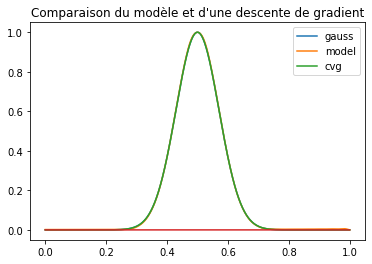

In [9]:
plt.plot(t,sim.BasisChangeInv(sim.BasisChange(x)),label="gauss")
plt.plot(t,sim.BasisChangeInv(x01[0,0].numpy()),label="model")
plt.plot(t,sim.BasisChangeInv(xkc),label="cvg")
plt.plot(t,np.zeros(nx))
plt.title("Comparaison du modèle et d'une descente de gradient")
plt.legend()

#### Entrée égale au biais

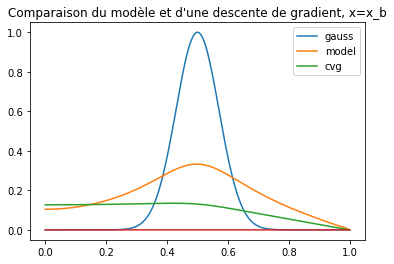

In [10]:
plt.plot(t,sim.BasisChangeInv(sim.BasisChange(x)),label="gauss")
plt.plot(t,sim.BasisChangeInv(x11[0,0].numpy()),label="model")
plt.plot(t,sim.BasisChangeInv(xky),label="cvg")
plt.plot(t,np.zeros(nx))
plt.title("Comparaison du modèle et d'une descente de gradient, x=x_b")
plt.legend()

### Stabilité et constante de lipschitz

#### Calcul de constante de lipschitz

In [11]:
# Semi norm, U1 = (1,1)
mymodel.Lipschitz(opt1="semi",opt2="entree01")

2.5290292823885374

In [12]:
# Virtual NN
mymodel.Lipschitz(opt1="total",opt2="entree01")

395.9499918151458

#### Ajout d' une perturbation

In [13]:
# Gaussian
t      = np.linspace(0,1,nx)
pert   = 0.1*np.exp(-(t-0.1)**2/1.0)
x      = np.exp(-(t-0.5)**2/0.01)
y      = sim.ComputeAdjoint(sim.Compute(x))
y_pert = sim.ComputeAdjoint(sim.Compute(x+pert))

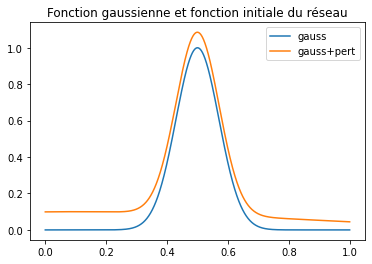

In [14]:
plt.plot(t,x,label="gauss")
plt.plot(t,x+pert,label="gauss+pert")
plt.title("Fonction gaussienne et fonction initiale du réseau")
plt.legend()

In [15]:
xi      = np.exp(-(t-0.6)**2/0.1)
xic     = sim.BasisChange(x)
xic     = torch.FloatTensor(xic.reshape(1,1,-1)).detach() # x_init
xb      = torch.FloatTensor(y.reshape(1,1,-1)).detach()   # x_bias
xb_pert = torch.FloatTensor(y_pert.reshape(1,1,-1)).detach()   # x_bias perturbé
with torch.no_grad():
    x01      = mymodel(xic,xb).detach()
    x01_pert = mymodel(xic,xb_pert).detach()

In [16]:
Lip_est = np.linalg.norm((x01_pert-x01).numpy())/np.linalg.norm(y_pert-y)
print("Constante de Lipschitz estimée =",Lip_est)

Constante de Lipschitz estimée = 2.510778901082456
